# Aprendizaje semi-supervisado

In [1]:
# Imports
import numpy as np
import pandas as pd
from local.library.Plot_semisupervised import plot_decision_boundary
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.base import clone

In [2]:
# -----------------------------
# Real-world Example Dataset: Moons (2D for visualization)
# -----------------------------
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
X_train, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

n_labeled = 40
X_labeled = X_train[:n_labeled]
y_labeled = y_train_full[:n_labeled]
X_unlabeled = X_train[n_labeled:]
y_unlabeled = y_train_full[n_labeled:]  # Hidden ground truth

In [6]:
np.unique(y_labeled)

array([0, 1])

## Aprendizaje supervisado

Usando sólo la porción con etiquetas de la base de datos

Supervised (Labeled Only) Accuracy: 0.8933333333333333


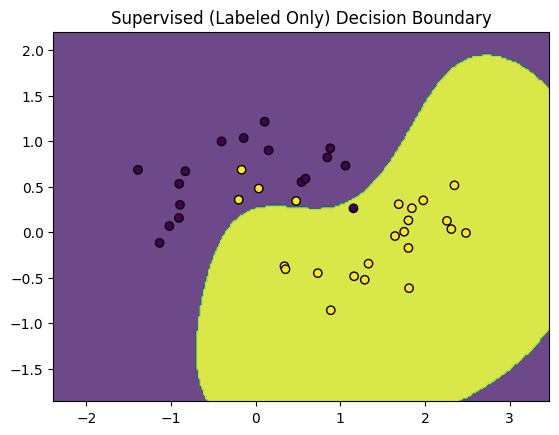

In [5]:
# -----------------------------
# Supervised Baseline with Only Labeled Data
# -----------------------------
model_supervised = SVC(probability=True)
model_supervised.fit(X_labeled, y_labeled)
y_pred_sup = model_supervised.predict(X_test)
print("Supervised (Labeled Only) Accuracy:", accuracy_score(y_test, y_pred_sup))
plot_decision_boundary(model_supervised, X_labeled, y_labeled, "Supervised (Labeled Only) Decision Boundary")

## Autoaprendizaje

Es un método tipo *wrapper* que usa un clasificador base para etiquetar las muestras sobre las que tiene mayor confiabilidad de manera recurrente [1]. A este método se le conoce también con el nombre de *pseudo-labels*.

In [3]:
# -----------------------------
# 1. Self-Training
# -----------------------------
class SelfTrainingClassifier:
    def __init__(self, base_estimator, confidence_threshold=0.8, max_iter=10):
        self.base_estimator = base_estimator
        self.confidence_threshold = confidence_threshold
        self.max_iter = max_iter

    def fit(self, X_labeled, y_labeled, X_unlabeled):
        X_l = X_labeled.copy()
        y_l = y_labeled.copy()
        X_u = X_unlabeled.copy()

        for iteration in range(self.max_iter):
            model = clone(self.base_estimator)
            model.fit(X_l, y_l)
            probs = model.predict_proba(X_u)
            confident = np.max(probs, axis=1) >= self.confidence_threshold
            if not any(confident):
                break
            confident_indices = np.where(confident)[0]
            X_new = X_u[confident_indices]
            y_new = np.argmax(probs[confident_indices], axis=1)

            X_l = np.vstack([X_l, X_new])
            y_l = np.concatenate([y_l, y_new])

            X_u = np.delete(X_u, confident_indices, axis=0)

        self.model = model

    def predict(self, X):
        return self.model.predict(X)

Self-Training Accuracy: 0.8733333333333333


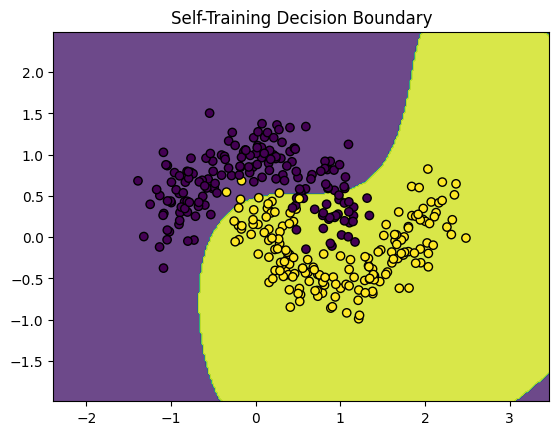

In [4]:
# Run Self-Training
self_training = SelfTrainingClassifier(SVC(probability=True), confidence_threshold=0.9)
self_training.fit(X_labeled, y_labeled, X_unlabeled)
y_pred_st = self_training.predict(X_test)
print("Self-Training Accuracy:", accuracy_score(y_test, y_pred_st))
plot_decision_boundary(self_training.model, np.vstack((X_labeled, X_unlabeled)), np.concatenate((y_labeled, y_unlabeled)), "Self-Training Decision Boundary")

## Co-aprendizaje

Es un método en el que dos clasificadores diferentes etiquetas los datos para el otro, idealmente usando diferentes conjuntos de características o fuentes de información [2].

In [7]:
# -----------------------------
# 2. Co-Training
# -----------------------------
def co_training(X_labeled, y_labeled, X_unlabeled, base_estimator_1, base_estimator_2, k=30, max_iter=10):
    X_l = X_labeled.copy()
    y_l = y_labeled.copy()
    X_u = X_unlabeled.copy()

    for _ in range(max_iter):
        model_1 = clone(base_estimator_1)
        model_2 = clone(base_estimator_2)
        model_1.fit(X_l, y_l)
        model_2.fit(X_l, y_l)

        probs_1 = model_1.predict_proba(X_u)
        probs_2 = model_2.predict_proba(X_u)

        confident_1 = np.argsort(-np.max(probs_1, axis=1))[:k]
        confident_2 = np.argsort(-np.max(probs_2, axis=1))[:k]

        new_X = np.vstack((X_u[confident_1], X_u[confident_2]))
        new_y = np.hstack((np.argmax(probs_1[confident_1], axis=1),
                           np.argmax(probs_2[confident_2], axis=1)))

        X_l = np.vstack([X_l, new_X])
        y_l = np.concatenate([y_l, new_y])

        X_u = np.delete(X_u, np.union1d(confident_1, confident_2), axis=0)
        if len(X_u) == 0:
            break

    final_model = clone(base_estimator_1)
    final_model.fit(X_l, y_l)
    return final_model

Co-Training Accuracy: 0.9666666666666667


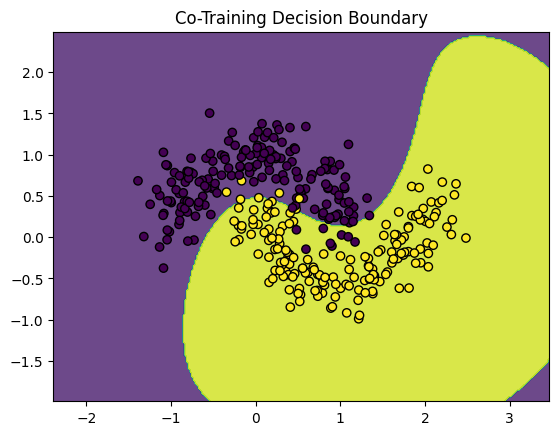

In [8]:
# Run Co-Training
co_model = co_training(X_labeled, y_labeled, X_unlabeled, SVC(probability=True), KNeighborsClassifier(), k=10)
y_pred_co = co_model.predict(X_test)
print("Co-Training Accuracy:", accuracy_score(y_test, y_pred_co))
plot_decision_boundary(co_model, np.vstack((X_labeled, X_unlabeled)), np.concatenate((y_labeled, y_unlabeled)), "Co-Training Decision Boundary")

## Propagación de etiquetas

Es un método basado en grafos que propaga la información de etiquetas a través de la variedad de los datos (*manifold*) [3].

Label Propagation Accuracy: 0.9866666666666667


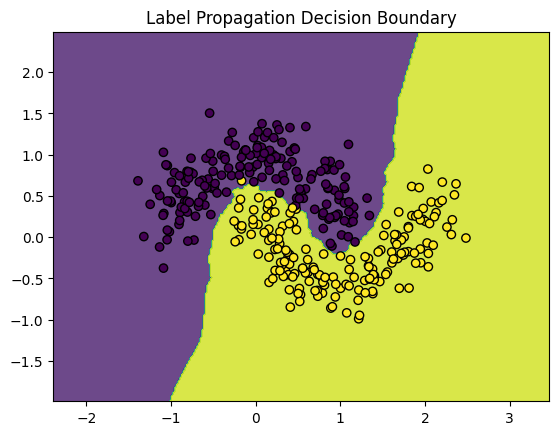

In [9]:
# -----------------------------
# 3. Label Propagation
# -----------------------------
X_lp = np.vstack((X_labeled, X_unlabeled))
y_lp = np.concatenate((y_labeled, [-1] * len(X_unlabeled)))

label_prop_model = LabelPropagation(kernel='knn')
label_prop_model.fit(X_lp, y_lp)
y_pred_lp = label_prop_model.predict(X_test)
print("Label Propagation Accuracy:", accuracy_score(y_test, y_pred_lp))
plot_decision_boundary(label_prop_model, np.vstack((X_labeled, X_unlabeled)), label_prop_model.transduction_, "Label Propagation Decision Boundary")

Una variante de este método es [LabelSpreading](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html)